# Housing Analysis in King County, Washington
### EDA, data cleaning, feature engineering notebook

In [24]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np 
import csv

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as sms
import scipy.stats as stats
from statsFunctions import check_model as sf
from pltfunctions import hist_kde_plots
from haversine import haversine
from math import sqrt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r'data\kc_house_data.csv')

### Data description as follows
![title](img/headers.png)

In [25]:
df.info() # a good initial picture of the data
# initial thoughts for necessary data and a regression upon seeing the data -
# price is y target
# 1) Unique identifiers (column= id) are unnecessary for a regression
# 2) lat and long wont be needed if include zipcode and will just be noise (decided to keep lat/long over zip)
# 3) square footage and home quality is likely to change based on location
# 4) anticipate autocorrelation between location and home features - dropping zipcode and keeping lat long
# 5) date - as time goes on, home prices are likely to go up - if the sales are all within a close time frame then we can ignore date
# 6) nearest 15 neighbors data - will autocorrelate with homes nearby, remove data
# 7) already have square footage of home, remove above and below ground sqft

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [26]:
# before we drop any null values (in yr_renovated and waterfront specifically) we should address the issues above.
df_init = df.drop(columns=['id','sqft_living15','sqft_above','sqft_basement']) 
# filter for more recent home sales
df_init['date'].unique() 
# can remove date and null values
print(df['yr_renovated'].unique())
print(df.groupby(df['yr_renovated']).count())
# given that these dates are very spread out and also that 17011 of the homes sold out have no renovation year at all, I will remove the data for the purposes of a linear regression

[   0. 1991.   nan 2002. 2010. 1992. 2013. 1994. 1978. 2005. 2003. 1984.
 1954. 2014. 2011. 1983. 1945. 1990. 1988. 1977. 1981. 1995. 2000. 1999.
 1998. 1970. 1989. 2004. 1986. 2007. 1987. 2006. 1985. 2001. 1980. 1971.
 1979. 1997. 1950. 1969. 1948. 2009. 2015. 1974. 2008. 1968. 2012. 1963.
 1951. 1962. 1953. 1993. 1996. 1955. 1982. 1956. 1940. 1976. 1946. 1975.
 1964. 1973. 1957. 1959. 1960. 1967. 1965. 1934. 1972. 1944. 1958.]
                 id   date  price  bedrooms  bathrooms  sqft_living  sqft_lot  \
yr_renovated                                                                    
0.0           17011  17011  17011     17011      17011        17011     17011   
1934.0            1      1      1         1          1            1         1   
1940.0            2      2      2         2          2            2         2   
1944.0            1      1      1         1          1            1         1   
1945.0            3      3      3         3          3            3         3   


In [27]:
df_init = df_init.dropna() # drop null values
df_init = df_init.drop(columns=['date','yr_renovated']) # drop date column

In [28]:
df_init.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long,sqft_lot15
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,1951,98125,47.7210,-122.319,7639
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1965,98136,47.5208,-122.393,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1987,98074,47.6168,-122.045,7503
5,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,3,11,2001,98053,47.6561,-122.005,101930
6,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,7,1995,98003,47.3097,-122.327,6819


In [29]:
df_init.info() # data is all in integer or float dtype

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15762 entries, 1 to 21596
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        15762 non-null  float64
 1   bedrooms     15762 non-null  int64  
 2   bathrooms    15762 non-null  float64
 3   sqft_living  15762 non-null  int64  
 4   sqft_lot     15762 non-null  int64  
 5   floors       15762 non-null  float64
 6   waterfront   15762 non-null  float64
 7   view         15762 non-null  float64
 8   condition    15762 non-null  int64  
 9   grade        15762 non-null  int64  
 10  yr_built     15762 non-null  int64  
 11  zipcode      15762 non-null  int64  
 12  lat          15762 non-null  float64
 13  long         15762 non-null  float64
 14  sqft_lot15   15762 non-null  int64  
dtypes: float64(7), int64(8)
memory usage: 1.9 MB


In [30]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','sqft_lot15','floors','waterfront','view','condition','grade','yr_built','yr_renovated','lat','long']

bedrooms


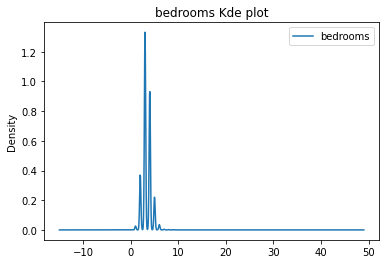

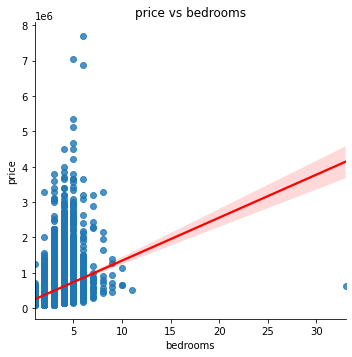

bathrooms


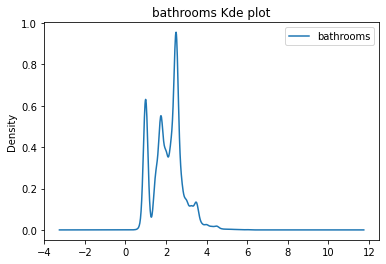

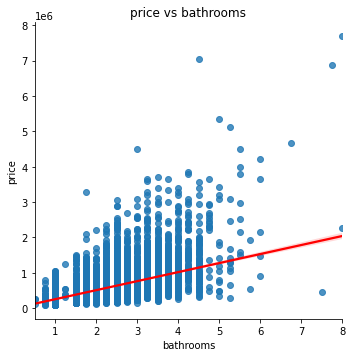

sqft_living


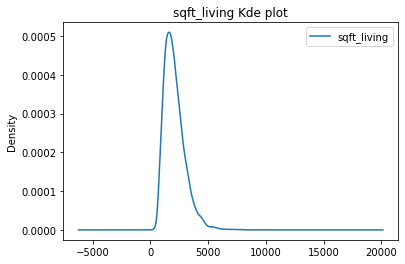

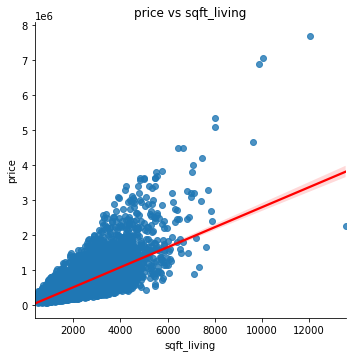

sqft_lot


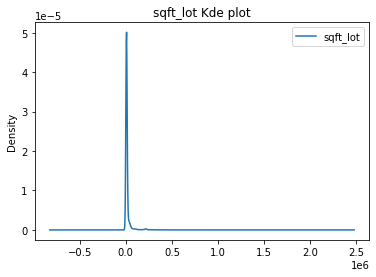

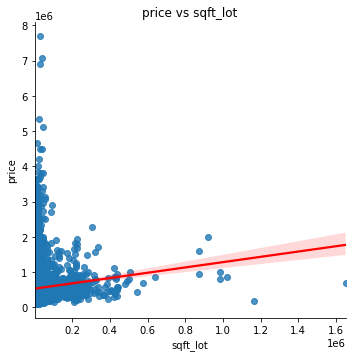

sqft_lot15


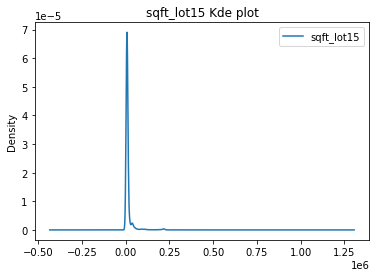

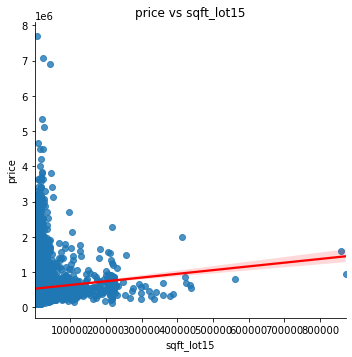

floors


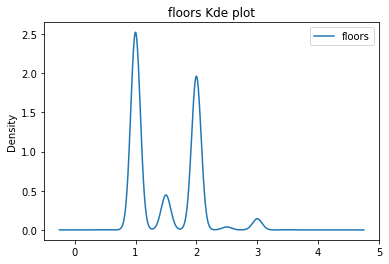

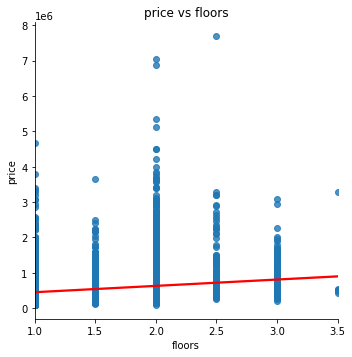

waterfront


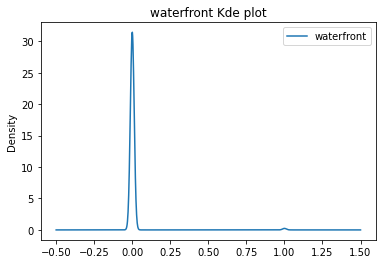

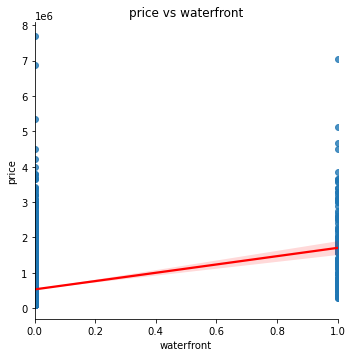

view


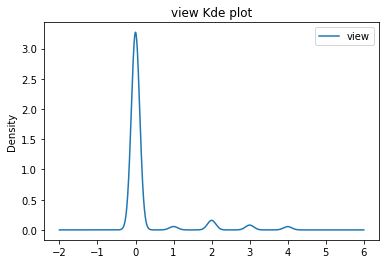

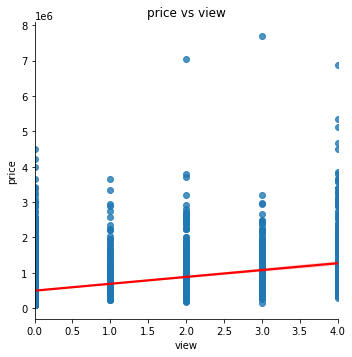

condition


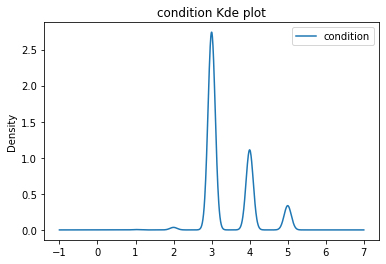

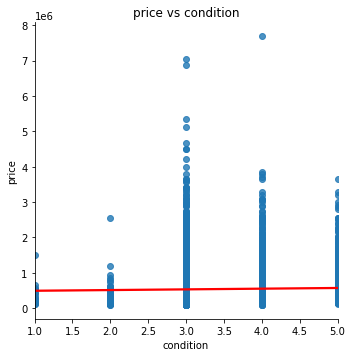

grade


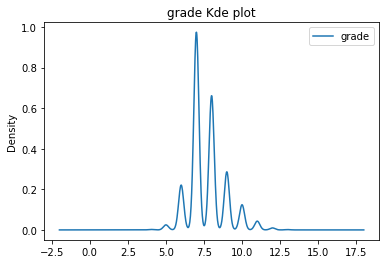

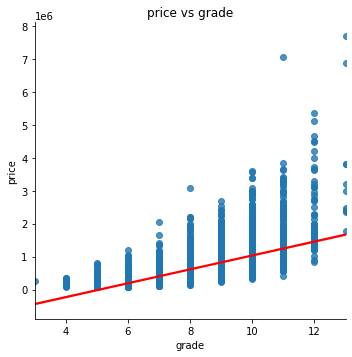

yr_built


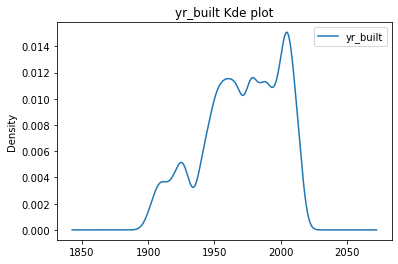

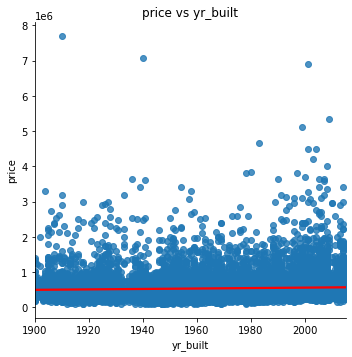

yr_renovated


KeyError: 'yr_renovated'

In [9]:
for feature in features:
    hist_kde_plots(feature,'price',df_init)

In [31]:
# funky data in the following columns - 1) yr_renovated - a lot of homes that haven't been
# renovated and they are all listed as 0's. Need to reconcile this data - because of groupby count analysis above decided to just remove this data (<17000 homes were never renovated per original dataset)
# 2) remove any price data that is greater than 3 standard deviations from the mean
df_init.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long,sqft_lot15
count,1.576200e+04,15762.000000,15762.000000,15762.000000,1.576200e+04,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000
mean,5.413172e+05,3.378949,2.120797,2084.512372,1.528082e+04,1.495147,0.007613,0.229984,3.410862,7.663748,1971.111217,98077.558241,47.559177,-122.213520,12900.415556
std,3.722258e+05,0.935301,0.766772,918.617686,4.182288e+04,0.539352,0.086924,0.761324,0.651961,1.172238,29.336823,53.414906,0.138629,0.140706,27977.230059
min,8.200000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,1900.000000,98001.000000,47.155900,-122.519000,659.000000
25%,3.210000e+05,3.000000,1.750000,1430.000000,5.048500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1952.000000,98033.000000,47.469200,-122.328000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.602000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1975.000000,98065.000000,47.571000,-122.229000,7620.000000
75%,6.448750e+05,4.000000,2.500000,2550.000000,1.072000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,1997.000000,98117.000000,47.677400,-122.124000,10107.500000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,2015.000000,98199.000000,47.777600,-121.315000,871200.000000


In [32]:
df_init.isna().sum()

price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
waterfront     0
view           0
condition      0
grade          0
yr_built       0
zipcode        0
lat            0
long           0
sqft_lot15     0
dtype: int64

In [33]:
# remove outliers and data will be cleaned, can move on to feature engineering
# we can standartize the data as well to do this
# we can see that there are no homes below 3 standard deviations with the describe table
# however there are homes above 3 standard deviations of the mean price
z = abs(stats.zscore(df_init)) 
print(z)
threshold = 3
print(np.where(z>3))
avg_price = df_init['price'].mean()
stdev_price = df_init['price'].std()
upper_bound = avg_price + 3*stdev_price

# df_clean = df_init[(z < 3).all(axis=1)] # this doesnt work because we remove some data (waterfront) that we don't want to remove - remove only homes sold with a price above 3 standard deviations
df_clean = df_init[df_init['price']<upper_bound]

[[0.00891201 0.40517583 0.16850812 ... 1.16734842 0.74967289 0.1880666 ]
 [0.16840532 0.66403252 1.14666608 ... 0.2768393  1.27560722 0.2823963 ]
 [0.08413755 0.40517583 0.15754454 ... 0.41567829 1.19770555 0.19292785]
 ...
 [0.37966644 0.66403252 0.49456077 ... 0.34969792 1.05528338 0.20375843]
 [0.37402184 1.47438418 1.78780781 ... 0.25409085 0.60752848 0.38937955]
 [0.58116341 1.47438418 1.78780781 ... 0.25192673 0.60752848 0.41261346]]
(array([    3,     3,     3, ..., 15740, 15740, 15751], dtype=int64), array([ 2,  3, 14, ...,  6,  7,  3], dtype=int64))


In [34]:
df_clean.isna().sum()

price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
waterfront     0
view           0
condition      0
grade          0
yr_built       0
zipcode        0
lat            0
long           0
sqft_lot15     0
dtype: int64

In [35]:
df_clean.price.max() # have removed absurdly high priced homes from df
df_clean.waterfront.max() # where we discover we removed data that is binary with low standard deviation compared to the max, which is 1. 
# lets try a different method
df_clean.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long,sqft_lot15
count,1.548000e+04,15480.000000,15480.000000,15480.000000,1.548000e+04,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000
mean,5.084310e+05,3.362532,2.093169,2037.260401,1.507320e+04,1.487791,0.004522,0.203424,3.409044,7.613114,1971.053682,98077.850452,47.558118,-122.213209,12791.542442
std,2.615181e+05,0.926927,0.733848,834.955963,4.123850e+04,0.537843,0.067096,0.707149,0.650400,1.109891,29.239459,53.309799,0.139496,0.141449,27915.589542
min,8.200000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,1900.000000,98001.000000,47.155900,-122.519000,659.000000
25%,3.200000e+05,3.000000,1.500000,1420.000000,5.012750e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1952.000000,98033.000000,47.465475,-122.329000,5100.000000
50%,4.490000e+05,3.000000,2.250000,1900.000000,7.560000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1975.000000,98065.000000,47.569150,-122.229000,7584.000000
75%,6.275000e+05,4.000000,2.500000,2510.000000,1.050000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,1996.000000,98117.000000,47.678200,-122.123000,10014.500000
max,1.650000e+06,33.000000,7.500000,7350.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,12.000000,2015.000000,98199.000000,47.777600,-121.315000,871200.000000


In [36]:
# after having completed a regression, discovered that lat and long are not worthwhile in a regression analysis
# as a result, will create a distance from seattle feature to create a regression 

In [85]:
df_clean['lat'] = [round(i,4) for i in df_clean['lat']]
df_clean['long'] = [round(i,4) for i in df_clean['long']]

In [86]:
df_clean['geo_loc'] = list(zip(df_clean['lat'], df_clean['long']))

In [87]:
Seattle = [47.6219, -122.3517] # defining Seattle's location

In [88]:
distance = []
for i in df_clean['geo_loc']:
    distance.append((haversine((Seattle),(i), unit='mi')))
rounded = [round(i,4) for i in distance]

df_clean['distance'] = rounded

In [89]:
df_clean.info()
df_clean.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15480 entries, 1 to 21596
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        15480 non-null  float64
 1   bedrooms     15480 non-null  int64  
 2   bathrooms    15480 non-null  float64
 3   sqft_living  15480 non-null  int64  
 4   sqft_lot     15480 non-null  int64  
 5   floors       15480 non-null  float64
 6   waterfront   15480 non-null  float64
 7   view         15480 non-null  float64
 8   condition    15480 non-null  int64  
 9   grade        15480 non-null  int64  
 10  yr_built     15480 non-null  int64  
 11  zipcode      15480 non-null  int64  
 12  lat          15480 non-null  float64
 13  long         15480 non-null  float64
 14  sqft_lot15   15480 non-null  int64  
 15  geo_loc      15480 non-null  object 
 16  distance     15480 non-null  float64
dtypes: float64(8), int64(8), object(1)
memory usage: 2.8+ MB


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long,sqft_lot15,distance
count,1.548000e+04,15480.000000,15480.000000,15480.000000,1.548000e+04,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000
mean,5.084310e+05,3.362532,2.093169,2037.260401,1.507320e+04,1.487791,0.004522,0.203424,3.409044,7.613114,1971.053682,98077.850452,47.558118,-122.213209,12791.542442,12.126486
std,2.615181e+05,0.926927,0.733848,834.955963,4.123850e+04,0.537843,0.067096,0.707149,0.650400,1.109891,29.239459,53.309799,0.139498,0.141449,27915.589542,7.098748
min,8.200000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,1900.000000,98001.000000,47.156000,-122.519000,659.000000,0.357500
25%,3.200000e+05,3.000000,1.500000,1420.000000,5.012750e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1952.000000,98033.000000,47.465000,-122.329000,5100.000000,6.281050
50%,4.490000e+05,3.000000,2.250000,1900.000000,7.560000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1975.000000,98065.000000,47.569000,-122.229000,7584.000000,10.776850
75%,6.275000e+05,4.000000,2.500000,2510.000000,1.050000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,1996.000000,98117.000000,47.678000,-122.123000,10014.500000,16.846850
max,1.650000e+06,33.000000,7.500000,7350.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,12.000000,2015.000000,98199.000000,47.778000,-121.315000,871200.000000,48.629200


In [90]:
df_clean.isna().sum()

price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
waterfront     0
view           0
condition      0
grade          0
yr_built       0
zipcode        0
lat            0
long           0
sqft_lot15     0
geo_loc        0
distance       0
dtype: int64

In [91]:
# send data to a csv!
df_clean.to_csv(r'data\CleanHousing.csv')


In [92]:
# checking for OLS assumptions:
# 1) the regression model is 'linear in parameters'
# 2) There is a random sampling of observations
# 3) The conditional mean should be zero, ie the expected value of the mean of the error terms should be zero
# 4) There is no multi-collinearity (no features can be derived from other features' values)
# 5) There is homoscedasticity and no autocorrelation
# 6) Error terms should be normally distributed